# A Brief Overview of ANN

Open in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/ts2024/blob/main/09-ANN.ipynb)

## Introduction

Until now he have studied the ARIMA class of models for time series forecasting. In this notebook we will show how artificial neural networks (ANN) can be used for time series forecasting. For a demonstration, we will use the `pytorch` library to implement a couple of simple neural networks for time series forecasting.

Before we turn to time series modeling, let's briefly discuss the basics of ANN for regression and we will start with the linear regression model that we studied in econometrics.

## Linear Regression

In linear regression we have a set of predictor variables $x_1$, $x_2$, ..., $x_p$ and a target variable $y$. We try to approximate $y$ for a set of $n$ observations. 



In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import torch


dt = pd.DataFrame({
    'x1': np.random.randn(100),
    'x2': np.random.randn(100),
})

dt["y"] = 5 + 2 * dt["x1"] - 3 * dt["x1"]**2 + 3 * dt["x2"] + np.random.randn(dt.shape[0])

dt = dt.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

dt.head()

,x1,x2,y
0,0.759512,0.341141,0.565363
1,0.102562,0.650636,0.359740
2,0.643051,0.412191,0.685691
3,0.656247,0.259700,0.611592
4,0.588910,0.467864,0.724592


In [110]:
dt.describe()

,x1,x2,y
count,100.000000,100.000000,100.000000
mean,0.456633,0.500011,0.620338
std,0.243338,0.202288,0.213150
min,0.000000,0.000000,0.000000
25%,0.234004,0.389967,0.491259
50%,0.461123,0.481340,0.669117
75%,0.646100,0.632474,0.775770
max,1.000000,1.000000,1.000000


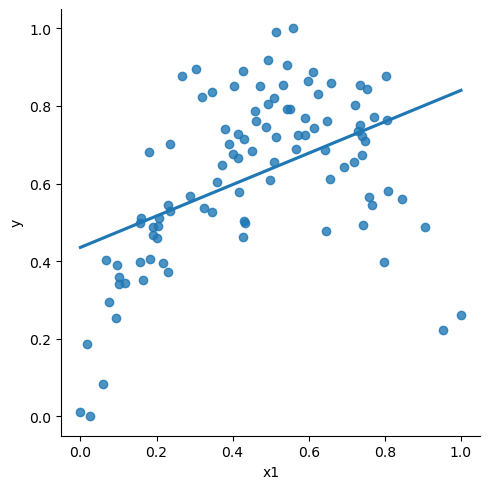

In [111]:
# Plot x1 and y and overlay the regression line

sns.lmplot(x='x1', y='y', data=dt, ci=None)
plt.show()

In econometrics we have written the linear regression model as for each observation $i = 1,\ldots,n$:

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \ldots + \beta_p x_{ip} + \epsilon_i
$$

Where $\beta_0$ is the intercept, $\beta_1, \ldots, \beta_p$ are the coefficients of the predictors, and $\epsilon_i$ is the error term for observation $i$. We can also write it more compactly as:

$$
y = X\beta + \epsilon
$$

Where $y$ is a vector of length $n$ and $\beta_0$ and $\beta_1$ are scalar parameters to be estimated, $x_1$ is a vector of length $n$, and $\epsilon$ is a vector of error terms of the same length. We can try to find the best values of $\beta_0$ and $\beta_1$ so that the predicted values of $y$ are as close as possible to the actual values of $y$.

$$
\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i}
$$

or 

$$
\hat{y} = X\hat{\beta}
$$

in matrix form. Here $\hat{y}$ is the predicted value of $y$ and $\hat{\beta}$ is the estimated vector of parameters.

If we are looking for "best" values of $\beta$ we must specify what good and bad means and this is the role of the loss function. The most common loss function for regression is the mean squared error (MSE) which is defined as:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

So the goal is to find the values of $\beta$ that minimize the MSE. We have actually done this in econometrics using the OLS method which resulted in the following formula for $\hat{\beta}$:

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

where $X^T$ is the transpose of $X$ and $(X^TX)^{-1}$ is the inverse of the matrix product of $X^T$ and $X$.


In [13]:
# The first ten rows of the data

dt.head(n = 10)

,x1,x2,y
0,0.717728,-0.886548,2.022583
1,1.148797,1.201121,7.129888
2,0.691947,-0.364245,3.959767
3,-1.660402,-0.714805,-8.564851
4,-1.390362,-0.591742,-6.108525
5,1.827375,-2.057321,-8.328457
6,-0.987304,-0.960762,-2.680887
7,1.341295,0.071748,1.987229
8,1.480597,-1.261479,-2.922440
9,-1.567671,-2.579640,-12.933676


In [112]:

y, X = dmatrices('y ~ x1', dt[:10])

print("The feature matrix X is:")
print(X)

# Initialize the beta vector

beta = np.array([0.1, 0.1])
print("The beta1 vector is:")
print(beta)

y_hat = X.dot(beta)

print("The predicted values are:")

print(y_hat)

The feature matrix X is:
[[1.         0.75951229]
 [1.         0.10256167]
 [1.         0.64305085]
 [1.         0.65624727]
 [1.         0.58890973]
 [1.         0.61262063]
 [1.         0.05991346]
 [1.         0.84618072]
 [1.         0.10200046]
 [1.         0.47136367]]
The beta1 vector is:
[0.1 0.1]
The predicted values are:
[0.17595123 0.11025617 0.16430509 0.16562473 0.15889097 0.16126206
 0.10599135 0.18461807 0.11020005 0.14713637]


In [113]:
# Calculate the residuals

residuals = y.squeeze() - y_hat

print("The residuals are:")
print(residuals)

print("The mean squared error is:", np.mean(residuals**2))

The residuals are:
[ 0.38941198  0.24948422  0.52138609  0.44596745  0.56570128  0.58144404
 -0.02310572  0.37623663  0.23032566  0.70445112]
The mean squared error is: 0.20340987636446156


In [114]:
# We can find the optimal beta values by minimizing the mean squared error

from scipy.optimize import minimize

def mse(beta, X, y):
    y_hat = X.dot(beta)
    residuals = y.squeeze() - y_hat
    return np.mean(residuals**2)

result = minimize(mse, beta, args=(X, y))
print("The optimal beta values are:")
print(result.x)

The optimal beta values are:
[0.27873799 0.5654595 ]


In [115]:
# Or by using a dedicated library (similar to the lm function in R)

import statsmodels.api as sm

model = sm.OLS(y, X)

result = model.fit()

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     8.248
Date:                Thu, 09 Jan 2025   Prob (F-statistic):             0.0208
Time:                        16:28:31   Log-Likelihood:                 4.5430
No. Observations:                  10   AIC:                            -5.086
Df Residuals:                       8   BIC:                            -4.481
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2787      0.110      2.540      0.0

/home/amarov/miniconda3/envs/ts2024/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Gradient Descent

There is also a more general way to find the best values of $\beta$ and that is by using the gradient descent algorithm. The idea is to start with some initial values of $\beta$ and then iteratively update the values of $\beta$ in the direction of the negative gradient of the loss function. The gradient of the loss function is the vector of partial derivatives of the loss function with respect to each parameter.

Consider first a very simple function of one variable:

$$
f(x) = x^2 - 2x + 1
$$

Its derivative is:

$$
f'(x) = 2x - 2
$$

and its minimum is at $x = -1$ (where the derivative is zero). We can find this minimum by starting at some initial value of $x$ and then iteratively updating $x$ in the direction of the negative gradient of $f(x)$:

$$
x_{t+1} = x_t - \eta f'(x_t)
$$

where $\eta$ a parameter that controls the speed of learning.


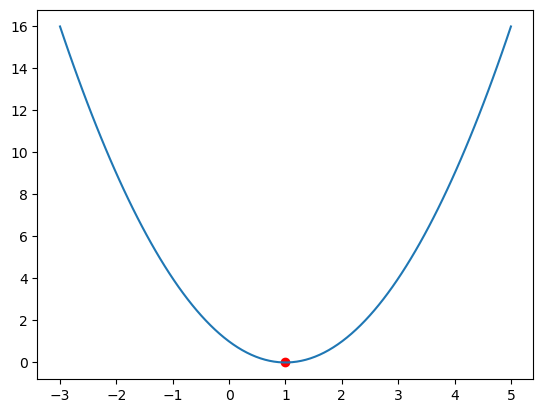

In [116]:
# Plot the minimum of the function

x = np.linspace(-3, 5, 100)

y = x**2 - 2 * x + 1

plt.plot(x, y)
plt.scatter(1, 0, color='red')
plt.show()


Step 0 x: 4 y: 9 gradient: 6
Step 1 x: 3.4 y: 5.759999999999999 gradient: 4.8
Step 2 x: 2.92 y: 3.686399999999999 gradient: 3.84
Step 3 x: 2.536 y: 2.3592960000000005 gradient: 3.072
Step 4 x: 2.2288 y: 1.5099494400000006 gradient: 2.4576000000000002
Step 5 x: 1.9830400000000001 y: 0.9663676416000002 gradient: 1.9660800000000003
Step 6 x: 1.786432 y: 0.6184752906240001 gradient: 1.572864
Step 7 x: 1.6291456 y: 0.3958241859993601 gradient: 1.2582912
Step 8 x: 1.50331648 y: 0.2533274790395903 gradient: 1.0066329600000001
Step 9 x: 1.402653184 y: 0.16212958658533783 gradient: 0.8053063680000001


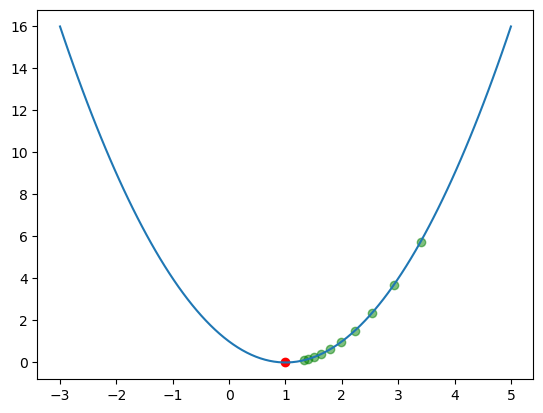

In [60]:
# Plot the gradient descent steps

x = np.linspace(-3, 5, 100)

y = x**2 - 2 * x + 1
d_y = 2 * x - 2

plt.plot(x, y)
plt.scatter(1, 0, color='red')

x = 4

for i in range(10):
    print("Step", i, "x:", x, "y:", x**2 - 2 * x + 1, "gradient:", 2 * x - 2)
    x = x - 0.1 * (2 * x - 2)    
    plt.scatter(x, x**2 - 2 * x + 1, color='green', alpha=0.5)
    

The same works for functions of multiple variables. The gradient of a function of multiple variables is a vector of partial derivatives. For example, consider the function:

$$
f(x_1, x_2) = x_1^2 + x_2^2
$$

Its gradient is:

$$
\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \end{bmatrix} = \begin{bmatrix} 2x_1 \\ 2x_2 \end{bmatrix}
$$

and its minimum is at $x_1 = 0$ and $x_2 = 0$. We can find this minimum by starting at some initial values of $x_1$ and $x_2$ and then iteratively updating $x_1$ and $x_2$ in the direction of the negative gradient of $f(x_1, x_2)$:

$$
x_{1,t+1} = x_{1,t} - \eta \frac{\partial f}{\partial x_1}
$$

$$
x_{2,t+1} = x_{2,t} - \eta \frac{\partial f}{\partial x_2}
$$

where $\eta$ a parameter that controls the speed of learning.

Step 0 x1: 4 x2: 4 f: 32 gradient: [8 8]
Step 1 x1: 3.2 x2: 3.2 f: 20.480000000000004 gradient: [6.4 6.4]
Step 2 x1: 2.56 x2: 2.56 f: 13.1072 gradient: [5.12 5.12]
Step 3 x1: 2.048 x2: 2.048 f: 8.388608 gradient: [4.096 4.096]
Step 4 x1: 1.6384 x2: 1.6384 f: 5.36870912 gradient: [3.2768 3.2768]
Step 5 x1: 1.31072 x2: 1.31072 f: 3.4359738368000006 gradient: [2.62144 2.62144]
Step 6 x1: 1.0485760000000002 x2: 1.0485760000000002 f: 2.199023255552001 gradient: [2.097152 2.097152]
Step 7 x1: 0.8388608000000002 x2: 0.8388608000000002 f: 1.4073748835532807 gradient: [1.6777216 1.6777216]
Step 8 x1: 0.6710886400000001 x2: 0.6710886400000001 f: 0.9007199254740995 gradient: [1.34217728 1.34217728]
Step 9 x1: 0.5368709120000001 x2: 0.5368709120000001 f: 0.5764607523034238 gradient: [1.07374182 1.07374182]


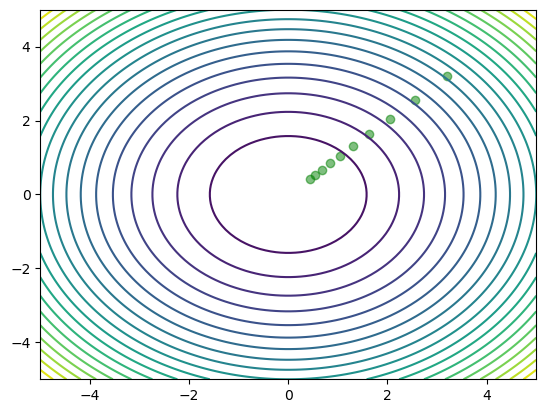

In [62]:
# Plot the steps of the gradient descent algorithm for the function of two variables

def f(x1, x2):
    return x1**2 + x2**2

def grad_f(x1, x2):
    return np.array([2 * x1, 2 * x2])

x1 = 4
x2 = 4

for i in range(10):
    print("Step", i, "x1:", x1, "x2:", x2, "f:", f(x1, x2), "gradient:", grad_f(x1, x2))
    x1 = x1 - 0.1 * grad_f(x1, x2)[0]
    x2 = x2 - 0.1 * grad_f(x1, x2)[1]
    plt.scatter(x1, x2, color='green', alpha=0.5)

# Plot the function as countour plot

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)

X1, X2 = np.meshgrid(x1, x2)

Y = X1**2 + X2**2

plt.contour(X1, X2, Y, levels=20)


## The Linear Regression as a Neural Network

Artificial neural networks are inspired by the way the human brain works and are a network of interconnected nodes (neurons) that are organized in layers. The simplest neural network is the perceptron which consists of a single neuron.

![Perceptron with a single input](./figures/ANN/perceptron-single-input.png)

![Perceptron with two inputs](./figures/ANN/perceptron-two-inputs.png)

![Perceptron with multiple inputs](./figures/ANN/perceptron-multiple-inputs.png)

The prediction of the perceptron is simply the weighted sum of the inputs:

$$
\hat{y} = b_1 + w_1 x_1 + w_2 x_2 + \ldots + w_p x_p
$$

where $b_1$ is the bias term, $w_1, \ldots, w_p$ are the weights of the inputs, and $x_1, \ldots, x_p$ are the inputs. The perceptron can be seen as a linear regression model with a single neuron.

Note that the language here differs from the econometrics language. When we talk of bias in econometrics we mean a systematic error in the model. In neural networks, the bias is a parameter just the constant in the linear regression model.


In [117]:
# Torch model for the linear regression

import torch

X = torch.tensor(dt[["x1"]].values, dtype=torch.float32)
y = torch.tensor(dt["y"].values, dtype=torch.float32)

linmod = torch.nn.Linear(1, 1)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.SGD(linmod.parameters(), lr=0.01)

for i in range(400):
    optimizer.zero_grad()
    
    y_hat = linmod(X)
    
    loss = criterion(y_hat, y.view(-1, 1))
    
    loss.backward()
    
    optimizer.step()

    if i % 10 == 0:
        print("Epoch", i, "Loss:", loss.item())

print("The beta values are:")
print(linmod.weight.detach().numpy())

# The bias term

print("The bias term is:")
print(linmod.bias.detach().numpy())

Epoch 0 Loss: 0.23694749176502228
Epoch 10 Loss: 0.1607404202222824
Epoch 20 Loss: 0.11418022215366364
Epoch 30 Loss: 0.0857168510556221
Epoch 40 Loss: 0.06830044090747833
Epoch 50 Loss: 0.057627733796834946
Epoch 60 Loss: 0.05107216536998749
Epoch 70 Loss: 0.047030363231897354
Epoch 80 Loss: 0.044523730874061584
Epoch 90 Loss: 0.042954906821250916
Epoch 100 Loss: 0.041959233582019806
Epoch 110 Loss: 0.04131413996219635
Epoch 120 Loss: 0.04088374599814415
Epoch 130 Loss: 0.04058510437607765
Epoch 140 Loss: 0.04036755859851837
Epoch 150 Loss: 0.04020019620656967
Epoch 160 Loss: 0.040064115077257156
Epoch 170 Loss: 0.03994777798652649
Epoch 180 Loss: 0.03984411805868149
Epoch 190 Loss: 0.03974883258342743
Epoch 200 Loss: 0.03965925797820091
Epoch 210 Loss: 0.03957377374172211
Epoch 220 Loss: 0.03949137404561043
Epoch 230 Loss: 0.039411429315805435
Epoch 240 Loss: 0.03933355212211609
Epoch 250 Loss: 0.039257489144802094
Epoch 260 Loss: 0.03918306902050972
Epoch 270 Loss: 0.039110202342271

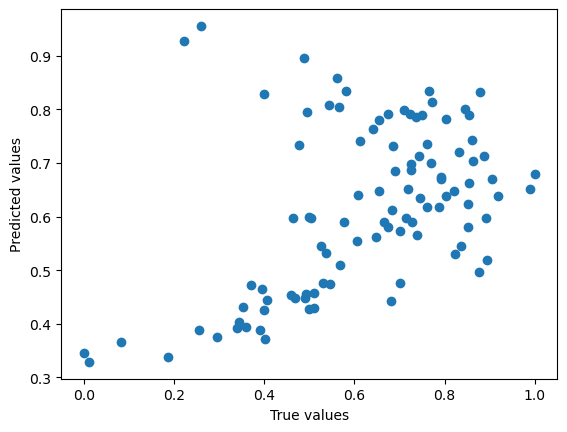

In [118]:
# It is useful to plot the predicted values against the true values

y_hat = linmod(X).detach().numpy()

plt.scatter(dt["y"], y_hat)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()


Until now we have only changed the notation (instead of $\beta_1$ and $\beta_0$ we have $w_1, \ldots, w_1$ and $b_1$) but the model is the same. The only different thing is that we used gradient descent to find the best values of $w_1$ and $b_1$ instead of the OLS method.

Things get more interesting when we add more layers to the network.

![Neural network with two nodes in one hidden layer, single input](./figures/ANN/ann-hidden-layer-single-input.png)

The graphic visualizes the following mathematical model:

$$
\begin{align*}
z_1 &= b_1 + w^{h}_{1} x_1 \\
z_2 &= b_2 + w^{h}_{2} x_1 \\
h_1 &= \sigma(z_1) \\
h_2 &= \sigma(z_2) \\
\hat{y} &=  b + w^{o}_1 h_1 + w^{o}_2 h_2
\end{align*}
$$

where $z_1$ and $z_2$ are the weighted sums of the inputs, $h_1$ and $h_2$ are the outputs of the hidden layer, $\sigma$ is the activation function, and $\hat{y}$ is the prediction of the network. The activation function is a non-linear function that introduces non-linearity to the model. Here we have used the sigmoid function as the activation function. The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

and maps the real numbers to the interval $(0, 1)$. The sigmoid function is used to introduce non-linearity to the model. If we used a linear activation function the model would be equivalent to a linear regression model.

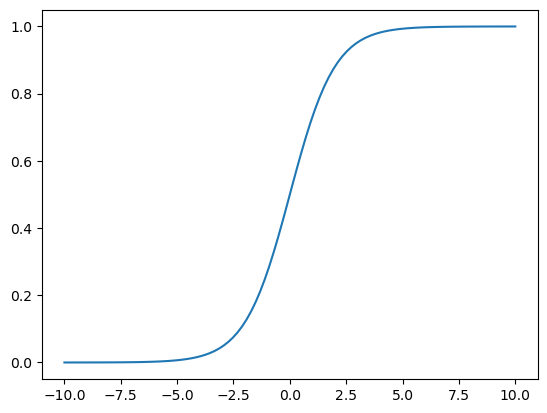

In [119]:
# Plot the sigmoid function

x = np.linspace(-10, 10, 100)

y = 1 / (1 + np.exp(-x))

plt.plot(x, y)
plt.show()


Epoch 0 Loss: 0.058987997472286224
Epoch 1000 Loss: 0.014202318154275417


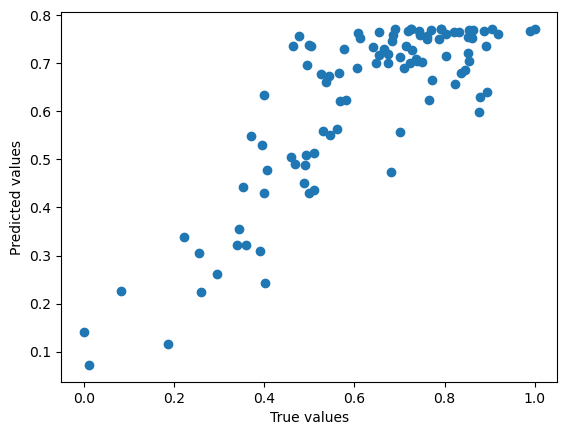

In [168]:
# Fit the model using pytorch

nn1 = torch.nn.Sequential(
    torch.nn.Linear(1, 9),
    torch.nn.Sigmoid(),
    torch.nn.Linear(9, 1)
)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(nn1.parameters(), lr=0.01)

X = torch.tensor(dt[["x1"]].values, dtype=torch.float32)
y = torch.tensor(dt["y"].values, dtype=torch.float32)

for i in range(1500):
    optimizer.zero_grad()
    
    y_hat = nn1(X)
    
    loss = criterion(y_hat, y.view(-1, 1))
    
    loss.backward()
    
    optimizer.step()

    if i % 1000 == 0:
        print("Epoch", i, "Loss:", loss.item())

# Plot the predicted values against the true values

y_hat = nn1(X).detach().numpy()

plt.scatter(dt["y"], y_hat)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()


In [164]:
# Print the weights and biases

print("The weights are:")
print(nn1[0].weight.detach().numpy())
print("The biases are:")
print(nn1[0].bias.detach().numpy())

print("The weights are:")
print(nn1[2].weight.detach().numpy())
print("The biases are:")
print(nn1[2].bias.detach().numpy())

The weights are:
[[-0.5069635]
 [ 9.822067 ]
 [ 6.1107917]
 [-0.8012252]
 [-1.4595551]
 [ 6.842906 ]
 [ 2.6828892]
 [-1.0488362]]
The biases are:
[ 0.70611465  1.2469362  -6.234843   -0.35926026  0.1900663   2.1820786
  0.53635     0.26960802]
The weights are:
[[-0.4930634   1.52056    -2.0486643  -0.5777411  -0.79893494  0.6027665
   0.3747458  -0.8099324 ]]
The biases are:
[-0.46822527]


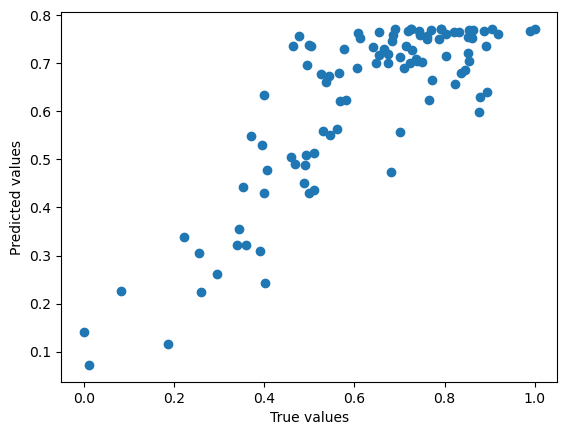

In [169]:
# Plot the predicted values against the true values

y_hat = nn1(X).detach().numpy()

plt.scatter(dt["y"], y_hat)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()


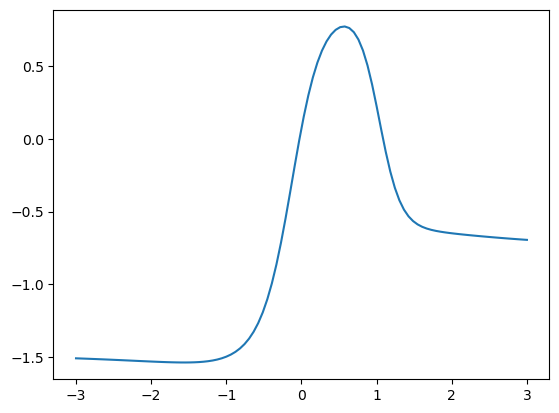

In [171]:
# Plot the prediction of the model

x = np.linspace(-3, 3, 100)

X = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)

y = nn1(X).detach().numpy()

plt.plot(x, y)
plt.show()


We can extend the mathematical model to handle two or more inputs:

![One hidden layer, two inputs](./figures/ANN/ann-hidden-layer-two-inputs.png)

Epoch 0 Loss: 1.9208155870437622
Epoch 1000 Loss: 0.01324398536235094


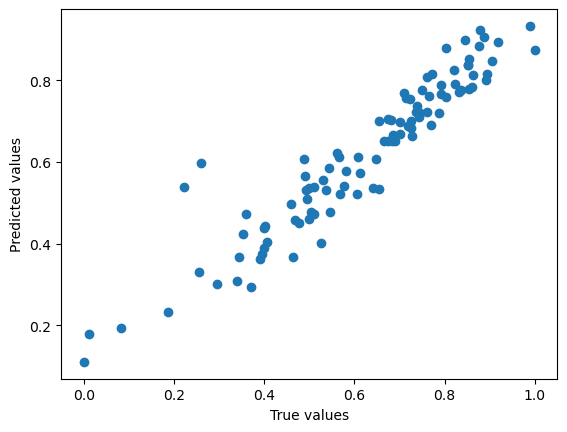

In [173]:
# Fit the model using pytorch

nn2 = torch.nn.Sequential(
    torch.nn.Linear(2, 9),
    torch.nn.Sigmoid(),
    torch.nn.Linear(9, 1)
)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(nn2.parameters(), lr=0.01)

X = torch.tensor(dt[["x1", "x2"]].values, dtype=torch.float32)
y = torch.tensor(dt["y"].values, dtype=torch.float32)

for i in range(1500):
    optimizer.zero_grad()
    
    y_hat = nn2(X)
    
    loss = criterion(y_hat, y.view(-1, 1))
    
    loss.backward()
    
    optimizer.step()

    if i % 1000 == 0:
        print("Epoch", i, "Loss:", loss.item())

# Plot the predicted values against the true values

y_hat = nn2(X).detach().numpy()

plt.scatter(dt["y"], y_hat)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

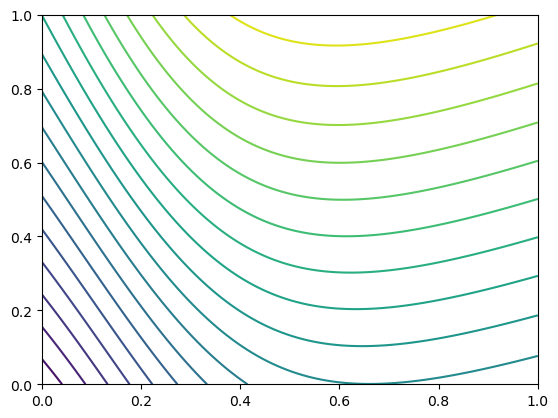

In [174]:
# Plot the prediction of the model for the two features

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

X1, X2 = np.meshgrid(x1, x2)

X = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=torch.float32)

y = nn2(X).detach().numpy().reshape(100, 100)

plt.contour(X1, X2, y, levels=20)
plt.show()


## Time series forecasting with ANN

We can use the same neural network architecture that we used for regression for time series forecasting. The only difference is that we use a time series as input instead of a set of predictors.

Let's say that we want to forecast the value of a time series $y_t$ at time $t$ using the values of the time series at times $t-1, t-2, \ldots, t-p$. We can use the following neural network architecture:
